# Exploring Speaker Voice Similarity Across British Accents Using WavLM
# - Part I

This notebook focuses on analyzing and evaluating the performance of a pre-trained speech model, WavLM (microsoft/wavlm-base-plus-sv), for speaker voice similarity.

The main objectives are:

* Creating and handling the dataset.
* Exploring the dataset.
* Extracting embeddings from voice samples using WavLM
* Computing speaker similarity using cosine similarity.
* To determine an optimal similarity threshold that distinguishes between speakers accurately.
* To evaluate the system using quantitative metrics such as accuracy and confusion matrices.
* To explore embedding spaces using dimensionality reduction techniques like t-SNE or PCA for clustering analysis.

The outcomes will inform the potential use of WavLM in Speaker Identification (SID) or Speaker Diarization systems and highlight key performance insights and limitations.

This notebook focuses only on the first three points from the above list.
Further work can be seen [here](https://github.com/BahneTP/Speaker-Voice-Similarity-Analysis/blob/main/Embedding_Analysis.ipynb), and an  [extensive report here.](https://github.com/BahneTP/Speaker-Voice-Similarity-Analysis/blob/main/Bahne_Thiel_Peters_Exploring_Speaker_Voice_Similarity_Across_British_Accents_Using_WavLM.pdf)

# Dataset

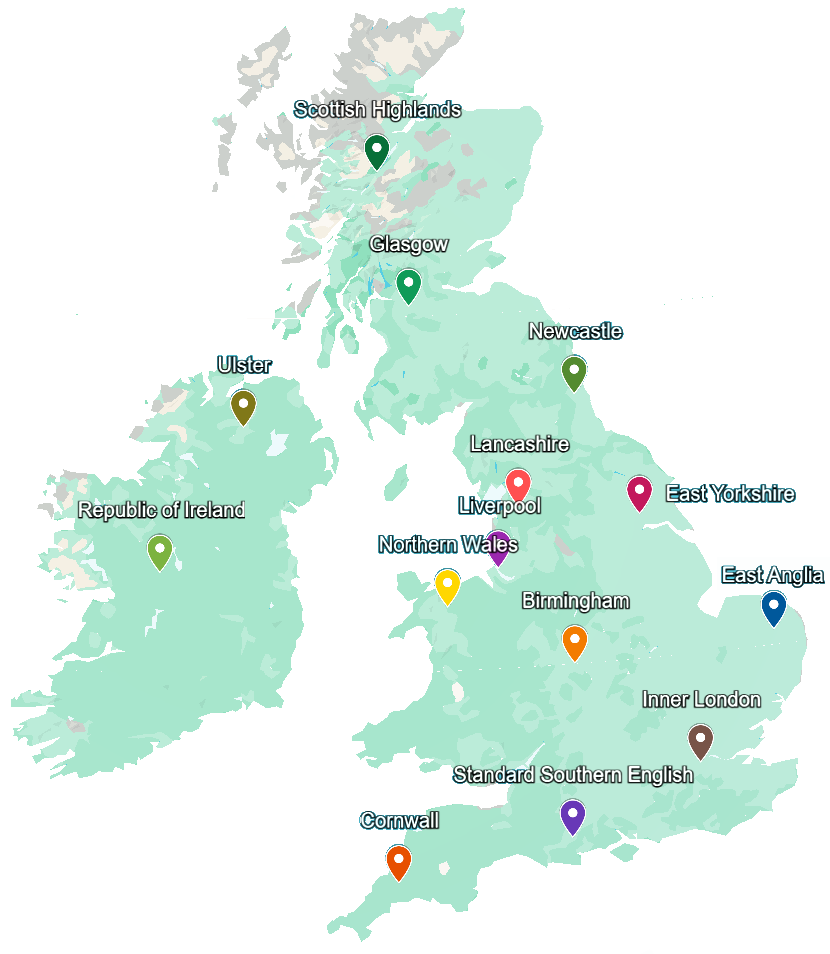

We will work with the [**Accents of the British Isles (ABI-1) Corpus**](), which includes speech data from 285 speakers with fourteen different accents, containing three audio-files spoken each by male and female. For more details read the EDA part.

# 1. Implementing the Dataset

## 1.1 Loading the Data
We begin by downloading the dataset from [this link](https://drive.google.com/file/d/18FWBn4B6gQifOtf1C9JCQv4Lrs8C1uvu/view?usp=share_link). Initially, we download the data as a zip file, which is then extracted for further use.

In [ ]:
import sys
import transformers
import torch

print("Python version:", sys.version)
print("Transformers version:", transformers.__version__)
print("PyTorch version:", torch.__version__)


Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Transformers version: 4.47.1
PyTorch version: 2.5.1+cu121


In [ ]:
import gdown
import zipfile
import os

#Download the Dataset.
download_url = "https://drive.google.com/uc?id=18FWBn4B6gQifOtf1C9JCQv4Lrs8C1uvu"
output_zip = "/content/file.zip"
gdown.download(download_url, output_zip, quiet=True)

#Extract the ZIP file.
extract_dir = "/content/AB-1"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## 1.2 Preprocessing the Dataset


The download includes two folders: *ABI-1 Corpus* and *_MACOSX.* Since we do not need the latter, we can safely delete it.

In [ ]:
import shutil

# 'rmtree' recursively deletes the folder.
shutil.rmtree("/content/AB-1/__MACOSX")

This is the directory structure: The "accents" folder contains subfolders for all 14 accents, each of which includes separate "male" and "female" folders. Within these, there are unique folders for individual narrators, each containing three audio files.

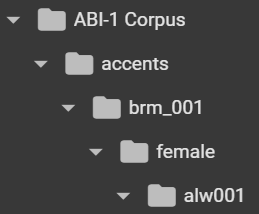

Since the ABI-1 Corpus contains additional data we don't need (such as transcripts and metadata), we can delete all files that do not begin with shortpassage or are not in .wav format.

In [ ]:
from scipy.io import wavfile
import pandas as pd
import os

root_dir = "/content/AB-1/ABI-1 Corpus/accents"

def create_dataset_and_clean_folder(dir):
    """
    Cleans the specified directory and its subdirectories.
    Deletes files that do not start with 'shortpassage' and are not '.wav' files.
    Removes empty directories and summarizes data for valid '.wav' files.
    """
    data_summary = []

    for root, dirs, files in os.walk(dir, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)

            # Delete files.
            if not (file.endswith('.wav') and file.startswith('shortpassage')):
                os.remove(file_path)
            # Process valid '.wav' files.
            else:
                sample_rate, data = wavfile.read(file_path)
                duration = len(data) / sample_rate
                parts = root.split(os.sep)
                data_summary.append({
                    "accent": parts[-3] if len(parts) > 2 else "",
                    "gender": parts[-2] if len(parts) > 1 else "",
                    "narrator": parts[-1],
                    "file_name": file,
                    "duration_sec": duration
                })

        # Remove empty directories. There should not be any!
        if not os.listdir(root):
            os.rmdir(root)

    return pd.DataFrame(data_summary)

df = create_dataset_and_clean_folder(root_dir)

Now the *AB-1/ABI-1* Corpus folder only contains folders and files we need for later.

# 2. Exploratory Data Analysis (EDA)
Before loading the model and analyzing the voice similarities, let's first take an overview of the data.

To easily access the full names of the accents for later visualization in plots, we have created a mapping structure. This will be used to add an additional column to the dataframe:

In [ ]:
accent_mapping = {
    'nwa_001': 'Northern Wales',
    'eyk_001': 'East Yorkshire',
    'shl_001': 'Scottish Highlands',
    'ilo_001': 'Inner London',
    'lan_001': 'Lancashire',
    'gla_001': 'Glasgow',
    'sse_001': 'Standard Southern English',
    'roi_001': 'Republic of Ireland',
    'lvp_001': 'Liverpool',
    'uls_001': 'Ulster',
    'crn_001': 'Cornwall',
    'ean_001': 'East Anglia',
    'brm_001': 'Birmingham',
    'ncl_001': 'Newcastle'
}
df['accent_full'] = df['accent'].map(accent_mapping)  # Mapping
accent_order = sorted(df['accent_full'].unique())     # Order alphabetical to ensure both plots are structured the same.
df['accent_full'] = pd.Categorical(df['accent_full'], categories=accent_order, ordered=True)

Next, let's create a plot to display the count of samples per gender for each accent. This will provide insights into the distribution of the data.

<ipython-input-15-6b8506893442>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_count = df.groupby(['accent_full', 'gender']).size().reset_index(name='count')


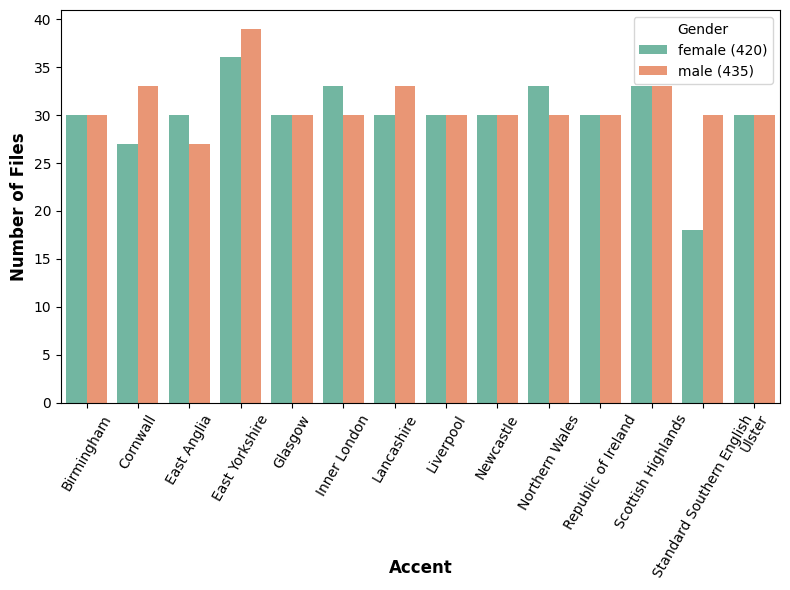

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gender_count_from_csv(df):
    """
    Plots a column chart showing the count of .wav files for each accent, split by gender.
    Displays the total number of samples for each gender next to the legend.
    """

    # Group and count data.
    gender_count = df.groupby(['accent_full', 'gender']).size().reset_index(name='count')

    # Calculate total counts per gender.
    total_gender_count = df.groupby('gender').size()

    # Plot using seaborn.
    plt.figure(figsize=(8, 6))
    sns.barplot(data=gender_count, x='accent_full', y='count', hue='gender', palette='Set2')
    plt.xlabel("Accent", fontsize=12, fontweight='bold', labelpad=-15)
    plt.ylabel("Number of Files", fontsize=12, fontweight='bold')
    plt.xticks(rotation=60)

    # Add the total count for each gender to the legend.
    handles, labels = plt.gca().get_legend_handles_labels()
    gender_labels = [label + f' ({total_gender_count[label]})' for label in labels]
    plt.legend(handles, gender_labels, title="Gender", loc='upper right')
    plt.tight_layout()
    plt.show()

plot_gender_count_from_csv(df)

Overall, there are slightly more male samples (50.88%) than female samples. The data is generally well-distributed across the accents, with the exception of Standard Southern English, which has significantly fewer female samples compared to male samples. Cornwall and East Yorkshire, on the other hand, have a higher number of female samples.

<ipython-input-12-4d6ba42fbd88>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='accent_full', y='duration_sec', palette='Set3')


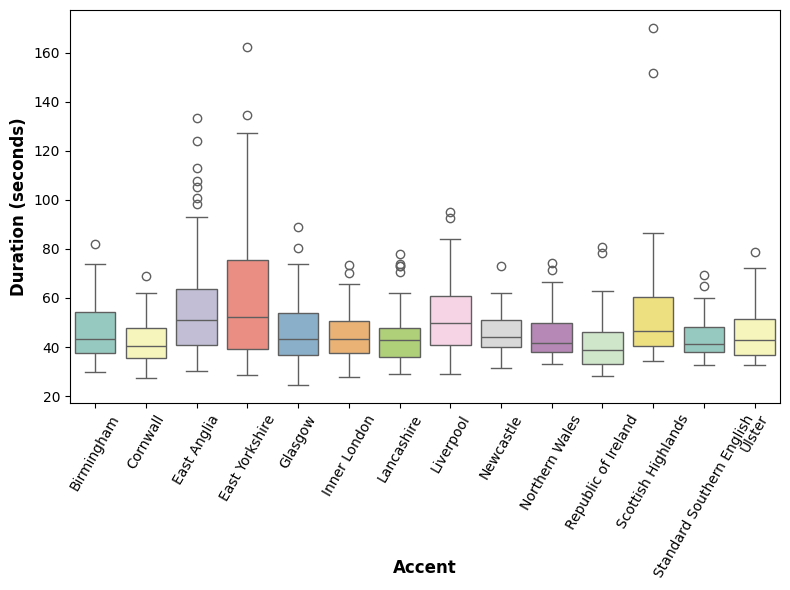

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_wav_durations_by_accent(csv_file):
    """
    Creates a boxplot showing the distribution of .wav file durations for each accent.
    """

    # Plot using seaborn's boxplot.
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='accent_full', y='duration_sec', palette='Set3')
    plt.xlabel("Accent", fontweight='bold', labelpad=-15, fontsize=12)
    plt.ylabel("Duration (seconds)", fontweight='bold', fontsize=12)
    plt.xticks(rotation=60)
    plt.tight_layout()

    plt.show()

plot_wav_durations_by_accent(df)

The plot shows that most accents have a median audio duration between 40 and 60 seconds. East Yorkshire stands out with the widest variability in duration, while accents like the Scottish Highlands tend to have generally longer durations. Outliers are present across multiple accents, indicating occasional audio files with significantly longer durations. Overall, the distribution of durations is fairly consistent, with a few accents showing more variation than others.









# 3. Embedding Calculation


### 3.1 Preprocessing
The preprocessing involves two steps: converting the audio to **mono** and resampling it to **16 kHz**, as the WavLM model was trained on data in this format. However, the first step, converting stereo to mono, is unnecessary since our dataset is already in mono. The second step, resampling to 16 kHz, is essential because the audio files in the dataset are currently sampled at 22,050 Hz.

In [ ]:
import os
import pandas as pd
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torchaudio
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize WavLM model and feature extractor.
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-plus-sv')
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-plus-sv').to(device)

def preprocess_wav(path):
    """
    Preprocesses a WAV file by resampling to 16kHz and converting to mono if needed.
    """
    # Load the WAV file.
    waveform, sample_rate = torchaudio.load(path)

    # Convert stereo to mono if necessary.
    if waveform.shape[0] > 1:
        print(1)
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample the audio to 16kHz, because the WavLM model is trained on this rate.
    transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = transform(waveform)

    return waveform

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

### 3.2 Embedding Extraction
To later compare the audios, we need to extract embeddings out of the model.

The waveform is passed through a feature** extractor**, which converts it into tensors suitable for the model. WavLM processes these inputs and outputs embeddings that capture the audio's unique characteristics.
**Aggregation** is not explicitly performed in the extract_embedding function. WavLM outputs embeddings in a fixed-length format when processing padded inputs, eliminating the need for external aggregation.

In [ ]:
def extract_embedding(wav_path):
    """
    Extracts embeddings from a WAV using the WavLM model.
    """

    # Preprocess the WAV file.
    waveform = preprocess_wav(wav_path)

    # Extract features.
    inputs = feature_extractor(waveform.squeeze().numpy(), return_tensors="pt", padding=True, sampling_rate=16000)
    # This is necessary, to ensure that the vector is handled by the gpu.
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Get embeddings.
    with torch.no_grad():
        embeddings = model(**inputs).embeddings

    return embeddings.squeeze().cpu().numpy() # Hand the vectors back to the cpu, to use numpy.


The following code calls the upper method on each audio-file and adds it into the dataframe.

In [ ]:
import warnings
from tqdm import tqdm
import torch
import os

def add_embeddings_to_df(df, root_dir):
    """
    Loops through the DataFrame, extracts embeddings for each .wav file,
    and saves them back to the DataFrame.
    """
    #Suppress PyTorch warnings.
    warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

    embeddings_list = []

    #This bar shows the progress.
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing embeddings", leave=True):
        if i % 10 == 0:
            torch.cuda.empty_cache()  # Clear GPU memory. Otherwise out of memory.

        #Construct the file path.
        file_path = os.path.join(root_dir, row['accent'], row['gender'], row['narrator'], row['file_name'])
        #Extract embeddings.
        embeddings_list.append(extract_embedding(file_path))

    # Add embeddings to the DataFrame using .loc to avoid SettingWithCopyWarning.
    df = df.copy()  # Create a copy of the DataFrame.
    df.loc[:, 'embedding'] = embeddings_list

    return df

df = add_embeddings_to_df(df, root_dir)
df.to_csv("abi1_dataset_with_embeddings.csv", index=False)

Processing embeddings:   1%|          | 5/855 [00:02<07:10,  1.97it/s]

In [ ]:
df.head()

,accent,gender,narrator,file_name,duration_sec,accent_full,embedding
0,gla_001,female,lxd001,shortpassagec_CT.wav,39.371429,Glasgow,"[-0.15204653, -0.103257336, -0.12303982, -0.00..."
1,gla_001,female,lxd001,shortpassageb_CT.wav,33.996916,Glasgow,"[-0.1667784, -0.10688769, -0.13540581, -0.0053..."
2,gla_001,female,lxd001,shortpassagea_CT.wav,34.121905,Glasgow,"[-0.17256695, -0.122389525, -0.1473812, -0.009..."
3,gla_001,female,mad001,shortpassagec_CT.wav,43.246077,Glasgow,"[-0.18117876, -0.12166425, -0.17096357, -0.143..."
4,gla_001,female,mad001,shortpassageb_CT.wav,39.121451,Glasgow,"[-0.16928044, -0.11791914, -0.17018943, -0.167..."


This saved DataFrame will be utilized in another Jupyter notebook focused on evaluating the dataset's embeddings. You can access it here: [LINK](https://)